# Prostate Cancer Worshop

## Initial analysis

### Imports

In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import pyarrow.parquet as pq
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import skew, kurtosis
from IPython.display import display

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score

from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score
from feature_engine.outliers import Winsorizer
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from bayes_opt import BayesianOptimization
from tqdm import tqdm
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score

import lightgbm as lgb
from xgboost import XGBClassifier


### LoadingData

In [2]:
df_train = pq.read_table('data/df_train.parquet').to_pandas()
df_test = pq.read_table('data/df_test.parquet').to_pandas()

df_train.shape

(23494, 46)

In [3]:
df_train.head()

,MEDICAMENTOS,MEDICINA ESPECIALIZADA,MEDICINA GENERAL,Cant_gr_flia,Cant_riesgos_flia_mean,min_Tiempo_CP_Fliar,Cant_Fliar_CP,psa_max_gr_flia,psa_min_gr_flia,Cant_Fliar_riesgos,...,CORONARIOS_FAMILIAR,CEREBRAL,CEREBRAL_FAMILIAR,ENFERMEDAD_RENAL,ENFERMEDAD_RENAL_FAMILIAR,OTROS_ANTECEDENTES_VASCULARES,Target,Pendiente,Intercepto,Promedio_costo
ID,,,,,,,,,,,,,,,,,,,,,
16484,12.0,3.0,3.0,2,0.0,NaN,0.0,NaN,NaN,0.0,...,0,0,0,0,0,0,0,58373.057143,-110021.200000,1.885690e+05
11528,6.0,1.0,1.0,2,0.5,NaN,0.0,NaN,NaN,1.0,...,0,0,0,0,0,0,0,19618.942857,-36176.133333,9.747050e+04
26630,1.0,0.0,2.0,2,0.0,NaN,0.0,NaN,NaN,0.0,...,0,0,0,0,0,0,1,398534.000000,-626628.000000,2.304723e+06
12586,6.0,0.0,2.0,2,0.0,NaN,0.0,NaN,NaN,0.0,...,0,0,0,0,0,0,0,1292.600000,13410.733333,5.380450e+04
11225,3.0,0.0,2.0,1,1.0,NaN,0.0,NaN,NaN,1.0,...,2,2,2,2,2,2,0,13728.714286,-27375.666667,4.134967e+04


In [4]:
df_test.head()

,MEDICAMENTOS,MEDICINA ESPECIALIZADA,MEDICINA GENERAL,Cant_gr_flia,Cant_riesgos_flia_mean,min_Tiempo_CP_Fliar,Cant_Fliar_CP,psa_max_gr_flia,psa_min_gr_flia,Cant_Fliar_riesgos,...,CORONARIOS,CORONARIOS_FAMILIAR,CEREBRAL,CEREBRAL_FAMILIAR,ENFERMEDAD_RENAL,ENFERMEDAD_RENAL_FAMILIAR,OTROS_ANTECEDENTES_VASCULARES,Pendiente,Intercepto,Promedio_costo
ID,,,,,,,,,,,,,,,,,,,,,
12596,2.0,4.0,2.0,2,0.000000,NaN,0.0,NaN,NaN,0.0,...,0,0,0,0,0,0,0,5.421180e+06,-1.256617e+07,9.611937e+06
29326,4.0,0.0,1.0,1,0.000000,NaN,0.0,NaN,NaN,0.0,...,0,0,0,0,0,0,0,-9.504343e+03,5.997787e+04,8.013800e+04
24338,0.0,0.0,1.0,2,0.000000,NaN,0.0,NaN,NaN,0.0,...,0,0,0,0,0,0,0,2.477143e+03,-5.780000e+03,1.734000e+04
11167,1.0,0.0,0.0,1,0.000000,NaN,0.0,NaN,NaN,0.0,...,1,0,1,0,1,0,0,3.597143e+03,-8.393333e+03,2.518000e+04
22074,36.0,0.0,1.0,3,0.666667,NaN,0.0,NaN,NaN,1.0,...,0,0,0,0,0,0,0,-9.042514e+03,6.309881e+05,5.993393e+05


In [ ]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10069 entries, 12596 to 22281
Data columns (total 45 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   MEDICAMENTOS                   10069 non-null  float64
 1   MEDICINA ESPECIALIZADA         10069 non-null  float64
 2   MEDICINA GENERAL               10069 non-null  float64
 3   Cant_gr_flia                   10069 non-null  int64  
 4   Cant_riesgos_flia_mean         10069 non-null  float64
 5   min_Tiempo_CP_Fliar            2 non-null      float64
 6   Cant_Fliar_CP                  10069 non-null  float64
 7   psa_max_gr_flia                76 non-null     float64
 8   psa_min_gr_flia                76 non-null     float64
 9   Cant_Fliar_riesgos             10069 non-null  float64
 10  cantidad_serv_flia             10069 non-null  float64
 11  Pendiente_flia                 10069 non-null  float64
 12  Intercepto_flia                10069 non-null  

In [6]:
print(df_test.index.name)


ID


In [7]:
df_test.reset_index(inplace=True)


In [8]:
df_test.columns

Index(['ID', 'MEDICAMENTOS', 'MEDICINA ESPECIALIZADA', 'MEDICINA GENERAL',
       'Cant_gr_flia', 'Cant_riesgos_flia_mean', 'min_Tiempo_CP_Fliar',
       'Cant_Fliar_CP', 'psa_max_gr_flia', 'psa_min_gr_flia',
       'Cant_Fliar_riesgos', 'cantidad_serv_flia', 'Pendiente_flia',
       'Intercepto_flia', 'Promedio_costo_flia', 'ESTADO_CIVI', 'PROGRAMA',
       'estrato', 'IMC', 'AGRUPACION_SISTOLICA', 'AGRUPACION_DIASTOLICA',
       'parentesco', 'EDAD', 'RIESGOS', 'CANTIDAD_SERVICIOS',
       'PERDIDA_DE_PESO', 'TIEMPO_ULTIMA_CITA', 'conteo_dx_diferentes',
       'TIEMPO_AFILIACION', 'CANCER_MAMA_FAMILIAR', 'CANCER_OTRO_SITIO',
       'CANCER_OTRO_SITIO_FAMILIAR', 'HIPERTENSION', 'HIPERTENSION_FAMILIAR',
       'DIABETES', 'DIABETES_FAMILIAR', 'CORONARIOS', 'CORONARIOS_FAMILIAR',
       'CEREBRAL', 'CEREBRAL_FAMILIAR', 'ENFERMEDAD_RENAL',
       'ENFERMEDAD_RENAL_FAMILIAR', 'OTROS_ANTECEDENTES_VASCULARES',
       'Pendiente', 'Intercepto', 'Promedio_costo'],
      dtype='object')

In [9]:
# Eliminar espacios adicionales si existen
df_train['estrato'] = df_train['estrato'].str.strip()
df_test['estrato'] = df_test['estrato'].str.strip()

# Reemplazar 'other' por NaN
df_train['estrato'].replace('other', np.nan, inplace=True)
df_test['estrato'].replace('other', np.nan, inplace=True)

# Definir el orden de las categorías
categorias_estrato = ['1', '2', '3']

# Convertir 'estrato' en una variable categórica con orden
df_train['estrato'] = pd.Categorical(df_train['estrato'], categories=categorias_estrato, ordered=True)
df_test['estrato'] = pd.Categorical(df_test['estrato'], categories=categorias_estrato, ordered=True)

# Verificar los cambios
print(df_train['estrato'].value_counts(dropna=False))
print(df_test['estrato'].value_counts(dropna=False))


estrato
1      17675
2       4063
3       1540
NaN      216
Name: count, dtype: int64
estrato
1      7526
2      1819
3       635
NaN      89
Name: count, dtype: int64


In [10]:
numeric_columns = [
    'Cant_gr_flia', 
    'Cant_riesgos_flia_mean', 
    'cantidad_serv_flia', 
    'CANTIDAD_SERVICIOS', 
    'conteo_dx_diferentes', 
    'EDAD', 
    'psa_max_gr_flia', 
    'psa_min_gr_flia', 
    'Pendiente', 
    'Pendiente_flia', 
    'Promedio_costo', 
    'Promedio_costo_flia', 
    'psa_max_gr_flia', 
    'psa_min_gr_flia', 
    'MEDICAMENTOS', 
    'MEDICINA ESPECIALIZADA', 
    'MEDICINA GENERAL', 
    'TIEMPO_AFILIACION', 
    'TIEMPO_ULTIMA_CITA', 
    'PERDIDA_DE_PESO', 
    'Intercepto', 
    'Intercepto_flia', 
    'Target',
    'Cant_Fliar_CP', 
    'Cant_Fliar_riesgos',
    'RIESGOS',
]

categorical_columns = [
    'AGRUPACION_DIASTOLICA', 
    'AGRUPACION_SISTOLICA', 
    'CANCER_MAMA_FAMILIAR', 
    'CANCER_OTRO_SITIO', 
    'CORONARIOS', 
    'CANCER_OTRO_SITIO_FAMILIAR',
    'CORONARIOS_FAMILIAR', 
    'CEREBRAL', 
    'CEREBRAL_FAMILIAR', 
    'DIABETES', 
    'DIABETES_FAMILIAR', 
    'ENFERMEDAD_RENAL', 
    'ENFERMEDAD_RENAL_FAMILIAR', 
    'HIPERTENSION', 
    'HIPERTENSION_FAMILIAR', 
    'OTROS_ANTECEDENTES_VASCULARES', 
    'ESTADO_CIVI', 
    'estrato', 
    'parentesco', 
    'PROGRAMA', 
]

### Feature Importance

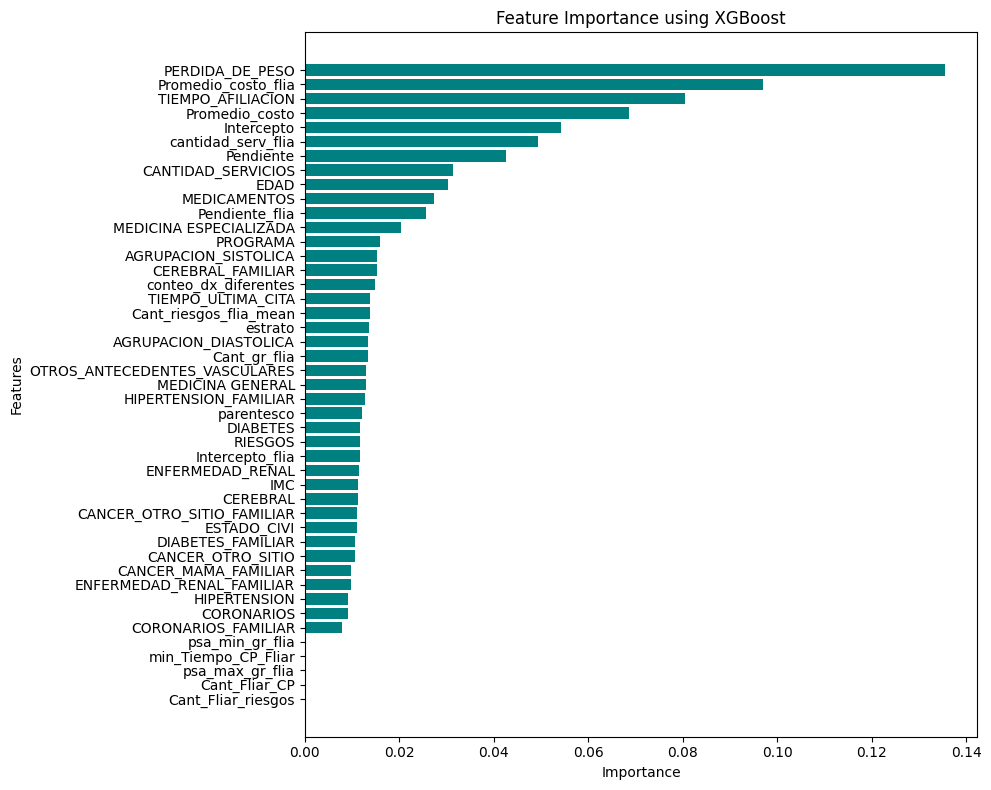

In [11]:
df_encoded = df_train.copy()
for column in numeric_columns + categorical_columns + ['IMC']:
    df_encoded[column] = df_encoded[column].astype('category')
X = df_encoded.drop(columns=['Target'])
y = df_encoded['Target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', enable_categorical=True)
model.fit(X_train, y_train)

importances = model.feature_importances_

feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 8))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='teal')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Feature Importance using XGBoost')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [12]:
features_to_drop = ['Cant_Fliar_riesgos', 'Cant_Fliar_CP', 'min_Tiempo_CP_Fliar', 'psa_min_gr_flia', 'psa_max_gr_flia', 'Target']

### Validate dropping features
- In order to be sure whether we decide to drop or not the already identified features, we will run a preliminary model to test with and without the features

In [13]:
def train_and_evaluate(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', enable_categorical=True)
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    f1 = f1_score(y_test, y_pred)
    
    return f1

# Model 1: With all features
X_all_features = df_encoded.drop(columns=['Target'])
y = df_encoded['Target']

f1_all_features = train_and_evaluate(X_all_features, y)
print(f"F1 Score with all features: {f1_all_features}")

# Model 2: Dropping variables with zero importance
X_reduced_features = df_encoded.drop(columns=['Target'] + features_to_drop)

f1_reduced_features = train_and_evaluate(X_reduced_features, y)
print(f"F1 Score after dropping zero-importance features: {f1_reduced_features}")

F1 Score with all features: 0.704248366013072
F1 Score after dropping zero-importance features: 0.704248366013072


After dropping additional features, including `'Cant_Fliar_riesgos'`, `'Cant_Fliar_CP'`, `'min_Tiempo_CP_Fliar'`, `'psa_min_gr_flia'`, `'psa_max_gr_flia'`, and `'CANCER_MAMA_FAMILIAR'`, the model's performance improved. The F1 score increased from **0.5207** (with all features) to **0.5384** (after removing these features), indicating that simplifying the model by excluding both zero-importance features and those with minimal predictive power can enhance the model’s performance. By reducing noise from less significant features, the model was able to generalize better and make more accurate predictions, showcasing the benefits of feature selection in machine learning.

## Preprocessing Pipeline_________________________________________________

In [14]:
updated_numeric_columns = [col for col in numeric_columns if col not in features_to_drop]
updated_categorical_columns = [col for col in categorical_columns if col not in features_to_drop]


In [15]:


# Definir transformador para columnas numéricas
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),  # Imputación de valores faltantes
    ('winsorizer', Winsorizer(capping_method='quantiles', tail='right', fold=0.07)),  # Manejo de outliers
    ('scaler', StandardScaler())  # Estandarización
])

# Definir transformador para columnas categóricas
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Imputación de valores faltantes
    ('onehot', OneHotEncoder(handle_unknown='ignore'))  # Codificación OneHot
])

# Crear el preprocesador con ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, updated_numeric_columns),  # Transformaciones numéricas
        ('cat', categorical_transformer, updated_categorical_columns)  # Transformaciones categóricas
    ]
)

# Crear el pipeline completo
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor)
])



#### Applying preprocessor pipeline
- Imputation and dropping

In [16]:
X = df_train.drop(columns=features_to_drop)
y = df_train['Target']

pipeline.fit(X)
X_train_transformed = pipeline.transform(X)


#### Converting the pipeline output into a readable data frame

In [17]:
# Combinar las columnas numéricas transformadas con las columnas categóricas transformadas
transformed_columns = (
    updated_numeric_columns +  # Columnas numéricas no cambian
    list(pipeline.named_steps['preprocessor'].transformers_[1][1]['onehot'].get_feature_names_out(updated_categorical_columns))  # Columnas categóricas transformadas
)

# Crear un nuevo DataFrame con las columnas transformadas
X_train_transformed_df = pd.DataFrame(X_train_transformed, columns=transformed_columns)

# Mostrar el DataFrame transformado
X_train_transformed_df


,Cant_gr_flia,Cant_riesgos_flia_mean,cantidad_serv_flia,CANTIDAD_SERVICIOS,conteo_dx_diferentes,EDAD,Pendiente,Pendiente_flia,Promedio_costo,Promedio_costo_flia,...,parentesco_Conyuge,parentesco_Hijo,parentesco_None,parentesco_Otros,parentesco_Padres,parentesco_Sin Descripcion,parentesco_Trabajador,PROGRAMA_PAC,PROGRAMA_POS,PROGRAMA_RS
0,-0.384157,-0.563530,0.461298,0.870051,1.418512,0.182457,0.259825,0.120281,0.190425,-0.498931,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,-0.384157,0.927491,0.041200,0.180986,0.174614,0.182457,0.123379,0.077596,-0.299259,-0.611393,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,-0.384157,-0.563530,0.554653,1.283491,1.418512,1.345805,0.266290,0.362661,2.866745,2.128716,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,-0.384157,-0.563530,-0.005478,-0.508079,0.174614,0.182457,0.058855,0.063343,-0.533978,-0.570745,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,-1.368600,2.418511,-0.798995,-0.232453,0.174614,-0.399217,0.102641,0.075774,-0.600927,-0.632206,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23489,0.600287,-0.563530,-0.098833,-0.783706,-1.069284,0.182457,0.077642,0.127715,-0.573780,-0.362175,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
23490,-1.368600,2.418511,-0.612285,-0.094640,0.174614,-1.562564,0.181621,0.077061,-0.337346,-0.623384,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
23491,-1.368600,-0.563530,-0.425575,0.456612,1.418512,-0.399217,0.110331,0.090371,-0.243586,-0.527062,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
23492,-1.368600,-0.563530,-0.939028,-0.783706,-0.447335,0.473294,0.063760,0.075885,-0.722144,-0.631443,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [18]:
def calculate_iqr(df, numeric_columns):
    """
    This function takes a dataframe and returns a dataframe that contains 
    the Interquartile Range (IQR) for each numeric column in the dataframe.
    
    Parameters:
    df (pd.DataFrame): Input dataframe
    
    Returns:
    pd.DataFrame: Dataframe containing IQR values for each numeric column
    """
    # Select numeric columns from the dataframe
    df_numeric_columns = df[numeric_columns]
    
    # Calculate Q1 (25th percentile) and Q3 (75th percentile) for each numeric column
    Q1 = df_numeric_columns.quantile(0.25)
    Q3 = df_numeric_columns.quantile(0.75)
    
    # Calculate the Interquartile Range (IQR)
    IQR = Q3 - Q1
    
    # Create a dataframe to store the IQR values
    iqr_df = pd.DataFrame({
        'Column': IQR.index,
        'IQR': IQR.values
    }).sort_values(by='IQR', ascending=False)
    
    return iqr_df


In [19]:
iqr_result = calculate_iqr(df_train, numeric_columns)
iqr_result

,Column,IQR
11,Promedio_costo_flia,236650.583333
10,Promedio_costo,146698.083333
21,Intercepto_flia,104989.850000
20,Intercepto,92525.866667
8,Pendiente,19009.150000
9,Pendiente_flia,16466.421429
17,TIEMPO_AFILIACION,206.000000
2,cantidad_serv_flia,29.000000
3,CANTIDAD_SERVICIOS,9.000000
5,EDAD,6.000000


In [20]:
iqr_result_after = calculate_iqr(X_train_transformed_df, updated_numeric_columns)
print(iqr_result_after)

                    Column       IQR
12        MEDICINA GENERAL  2.042646
13       TIEMPO_AFILIACION  2.002475
4     conteo_dx_diferentes  1.865847
5                     EDAD  1.745021
2       cantidad_serv_flia  1.353648
3       CANTIDAD_SERVICIOS  1.240318
1   Cant_riesgos_flia_mean  0.994014
10            MEDICAMENTOS  0.991865
0             Cant_gr_flia  0.984443
8           Promedio_costo  0.788549
14      TIEMPO_ULTIMA_CITA  0.764832
11  MEDICINA ESPECIALIZADA  0.650703
9      Promedio_costo_flia  0.644359
16              Intercepto  0.141326
17         Intercepto_flia  0.131303
6                Pendiente  0.066928
7           Pendiente_flia  0.045809
15         PERDIDA_DE_PESO  0.000000
18                 RIESGOS  0.000000


## **Prueba Felipe II**

=======================================

In [46]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.metrics import roc_auc_score
import xgboost as xgb
import numpy as np

# Eliminar columnas específicas que no son necesarias (ajústalas según tu dataset)
#X = X.drop(['psa_max_gr_flia', 'psa_min_gr_flia', 'min_Tiempo_CP_Fliar'], axis=1)

# Separar los datos en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Definir características numéricas y categóricas
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = X.select_dtypes(include=['object', 'category']).columns

# Definir columnas ordinales (ajusta estas columnas según tu dataset)
ordinal_cols = ['estrato', 'IMC']

# Asegurarse de que las columnas categóricas excluyan las ordinales
categorical_features = categorical_cols.difference(ordinal_cols)

# Crear transformadores para columnas numéricas
numeric_transformer = Pipeline(steps=[
    ('knn_imputer', KNNImputer(n_neighbors=8)),  # Imputación KNN
    ('scaler', StandardScaler())  # Estandarización
])

# Crear transformadores para columnas categóricas
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Imputación con moda
    ('onehot', OneHotEncoder(handle_unknown='ignore'))  # Codificación one-hot
])

# Crear transformadores para columnas ordinales
ordinal_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Imputación con moda
    ('ordinal_encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))  # Codificación ordinal
])

# Usar ColumnTransformer para aplicar las transformaciones adecuadas
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features),
        ('ord', ordinal_transformer, ordinal_cols)
    ])

# Crear el pipeline que aplique el preprocesamiento y luego el modelo XGBoost
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),  # Incluye el preprocesamiento
    ('classifier', xgb.XGBClassifier(
        use_label_encoder=True,
        eval_metric='logloss',
        max_depth=30,
        colsample_bytree=1.0,
        learning_rate=0.1,
        n_estimators=100,  # Puedes ajustar esto
        #random_state=42
    ))
])

# Entrenar el modelo
pipeline.fit(X_train, y_train)

# Predecir probabilidades en el conjunto de prueba
y_pred_proba = pipeline.predict_proba(X_test)[:, 1]  # Obtener probabilidades para la clase positiva

# Evaluar el modelo usando la métrica de ROC AUC
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"Test ROC AUC: {roc_auc:.4f}")

# Validación cruzada con 5 pliegues, evaluando ROC AUC
cv_scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='roc_auc')
print(f"Cross-Validation ROC AUC: {np.mean(cv_scores):.4f}")


Test ROC AUC: 0.8427
Cross-Validation ROC AUC: 0.7940


In [30]:
'''import pandas as pd

# Entrenar el modelo (esto ya lo tienes en la parte anterior)
pipeline.fit(X_train, y_train)

# Predecir probabilidades en el conjunto de prueba (df_test)
# Solo tomamos la probabilidad de la clase positiva (1)
y_pred_proba_kaggle = pipeline.predict_proba(df_test)[:, 1]

# Crear un DataFrame con las predicciones
submission_df = pd.DataFrame({
    'ID': df_test['ID'],  # Asegúrate de que 'df_test' tiene una columna 'ID'
    'Target': y_pred_proba_kaggle  # Probabilidad de la clase positiva
})

# Guardar el DataFrame como un archivo CSV
submission_df.to_csv('last_chance1.csv', index=False)
'''

